In [17]:
%%capture --no-stderr
%pip install --quiet -U langgraph

# The Simplest Graph

Let's build a simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [9]:
def node1(State):
    print("---------   Node 1   -----------------")
    return {"graph_state": State["graph_state"] + " I am"}
def node2(State):
    print("---------   Node 2   -----------------")
    return {"graph_state": State["graph_state"] + "  learning Cool Stuff!!"}
def node3(State):
    print("---------   Node 3  -----------------")
    return {"graph_state": State["graph_state"] + " building and deploying Agents!!"}

# Adding Edges to Nodes

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [25]:
import random
from typing import Literal

def decide_mood(State) -> Literal["node2", "node3"]:

    user_input = State["graph_state"]

    if random.random() > 0.5:
        return "node2"
    
    return "node3"

## Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

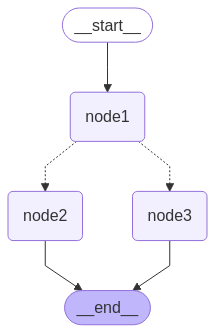

In [26]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_mood)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
graph.invoke({"graph_state" : "Hi, this is Kunal Lunia."})

---------   Node 1   -----------------
---------   Node 2   -----------------


{'graph_state': 'Hi, this is Kunal Lunia. I am  learning Cool Stuff!!'}

In [29]:
graph.invoke({"graph_state" : "Hi, this is Kunal Lunia."})

---------   Node 1   -----------------
---------   Node 3  -----------------


{'graph_state': 'Hi, this is Kunal Lunia. I am building and deploying Agents!!'}